# Synchronize to and Demodulate a QPSK Packet Received on POWDER

> Authors (alphabetical order):
> - Cassie Jeng
> - Neal Patwari
> - Aarti Singh
> - Jie Wang
> - Meles Gebreyesus Weldegebriel

January 2025, Version 0.2

This python notebook provides code to operate a QPSK demodulator in postprocesing for a signal recorded at a POWDER receiver. This includes perform frequency, phase, and symbol synchronization.  

You will first upload your data and setup the Python libraries and functions we will use.

## Setup this Python Environment

First, go to the file menu on the colab File menu and `Save a Copy in Drive`.  This is because this shared doc is a read only copy.

This python notebook came from [our github tx_rx_processing project page](https://github.com/npatwari/tx_rx_processing).  The following instructions assume you have the measurement zip file(s) from that public project, either by downloading files or cloning the repo.

In colab, we have to upload any file that colab needs besides this .ipynb file.  In particular we need to load the data files.  Currently colab requires us to upload one file at a time.  Because we're impatient, we zipped all of the data files together, and we'll upload that one zip file, and then unzip it.

To upload the file:
 - **Click on the folder icon** at the leftmost column of this page.  Then, you should see a `..` folder and a `sample_data` folder, and four icons above that directory listing.
 - **Click on the Upload icon**, which looks like a piece of paper with an up arrow on it.  
 - **Select and upload** the `Shout_meas_01-20-2023_00-40-44.zip` file (or whatever your measurement zip file is called). It asks you to confirm that it will delete them when your session expires (which means you need to do it again if the session expires).  Click OK.
 - **Run the exec command below** (`!unzip <your-file-name>.zip`, where you type in your file's name); and then wait for it to upload, which may take a few seconds.




In [1]:
!unzip Shout_meas_01-19-2025_QPSK.zip

Archive:  Shout_meas_01-19-2025_QPSK.zip
replace log? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


General info about Colab from Google:

> To execute the code in any cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.


### Import Libraries

In [2]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

## Load recorded data into the environment

Here we define some functions that load the measured data and the Shout metadata about the recording from the hdf5 file.

In [3]:
def get_time_string(timestamp):
    '''
    Helper function to get data and time from timestamp
    INPUT: timestamp
    OUTPUT: data and time. Example: 01-04-2023, 19:50:27
    '''
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

def JsonLoad(folder, json_file):
    '''
    Load parameters from the saved json file
    INPUT
    ----
        folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
        json_file: the json file with all the specifications. Example: '/save_iq_w_tx_gold.json'
    OUTPUT
    ----
        samps_per_chip: samples per chip
        wotxrepeat: number of repeating IQ sample collection w/o transmission. Used as an input to
        traverse_dataset() func
        rxrate: sampling rate at the receiver side
    '''
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']

    return rxrepeat, rxrate, txnodes, rxnodes

def traverse_dataset(meas_folder):
    '''
    Load data from hdf5 format measurement file
    INPUT
    ----
        meas_folder: path to the measurement folder. Example: "SHOUT/Results/Shout_meas_01-04-2023_18-50-26"
    OUTPUT
    ----
        data: Collected IQ samples w/ transmission. It is indexed by the transmitter name
        noise: Collected IQ samples w/o transmission. It is indexed by the transmitter name
        txrxloc: transmitter and receiver names
    '''
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r") #meas_folder
    print("Dataset meta data:", list(dataset.attrs.items()))
    for cmd in dataset.keys():
        print("Command:", cmd)
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for rx_gain in dataset[cmd][cmd_time].keys():
                print("   RX gain:", rx_gain)
                for rx in dataset[cmd][cmd_time][rx_gain].keys():
                    print("     RX:", rx)
                    print("       Measurement items:", list(dataset[cmd][cmd_time][rx_gain][rx].keys()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            print("  Timestamp:", get_time_string(cmd_time))
            print("  Command meta data:", list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                print("   TX:", tx)

                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("       RX gain:", rx_gain)
                        #print(dataset[cmd][cmd_time][tx][rx_gain].keys())
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            print("         RX:", rx)
                            #print("           Measurement items:", list(dataset[cmd][cmd_time][tx][rx_gain][rx].keys()))
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            print("         repeat", repeat)

                            samplesNotx =  dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        print("     TX gain:", tx_gain)
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            print("       RX gain:", rx_gain)
                            #print(dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys())
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                print("         RX:", rx, "; samples shape", np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples']))
                                #print("         Measurement items:", list(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx].keys()))
                                # print("         rxloc", (dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxloc'][0]))
                                # peak avg check
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))

        else:
            print('Unsupported command: ', cmd)

    return data, noise, txrxloc

def plotOnePSDForEachLink(rx_data, txrxloc, samp_rate=250000, repeats=4):
    for txname in rx_data:
        print(txname)
        for i in range(0, len(rx_data[txname]), repeats):
            plt.figure()
            # This code arbitrarily picks the 0 rep to plot.
            plt.psd(rx_data[txname][i][0], Fs = samp_rate/1000)
            plt.ylim(-110, -60)
            plt.yticks(ticks=[-110, -100, -90, -80, -70, -60])
            plt.grid('on')
            plt.title('TX: {} RX: {}'.format(txname, txrxloc[txname][i]))
            plt.xlabel('Frequency (kHz)')
            plt.tight_layout()
            plt.show()

Next you put in the folder name (same as the zip file name without the .zip extension).  This code then loads the data and prints info about the measurements in it.  The primary output is `rx_data`, which stores all of the complex-valued measurements.

In [4]:
# Load parameters from the JSON file which describe what was measured
folder = "./"
jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)
samp_rate = 250000.0
print(txlocs)

Dataset meta data: [('shout_version', 'eed2c2a')]
Command: saveiq_w_tx
  Timestamp: 01-19-2025, 23:36:40
  Command meta data: [('cmd', 'save_iq_w_tx'), ('nsamps', 8192), ('rxfreq', 3395000000.0), ('rxgain', 30.0), ('rxrate', 250000.0), ('rxrepeat', 4), ('rxwait_max', 2000), ('rxwait_min', 50), ('rxwait_random', True), ('rxwait_res', 'ms'), ('start_time', 1737329806.0), ('sync', True), ('timeout', 30), ('timezone', 'US/Mountain'), ('txfile', '/local/repository/shout/QPSK_signal_IH3_2025_v2.iq'), ('txfreq', 3395000000.0), ('txgain', 27.0), ('txrate', 250000.0), ('txwait', 3), ('use_lo_offset', True), ('wotxrepeat', 0)]
   TX: cbrssdr1-bes-comp
     TX gain: 27.0
       RX gain: 30.0
         RX: cbrssdr1-fm-comp ; samples shape (4, 8192)
   TX: cbrssdr1-fm-comp
     TX gain: 27.0
       RX gain: 30.0
         RX: cbrssdr1-bes-comp ; samples shape (4, 8192)
   TX: wo_tx
       RX gain: 30.0
         RX: cbrssdr1-bes-comp
         repeat 0
         RX: cbrssdr1-fm-comp
         repeat 0
['

250000.0
cbrssdr1-bes-comp


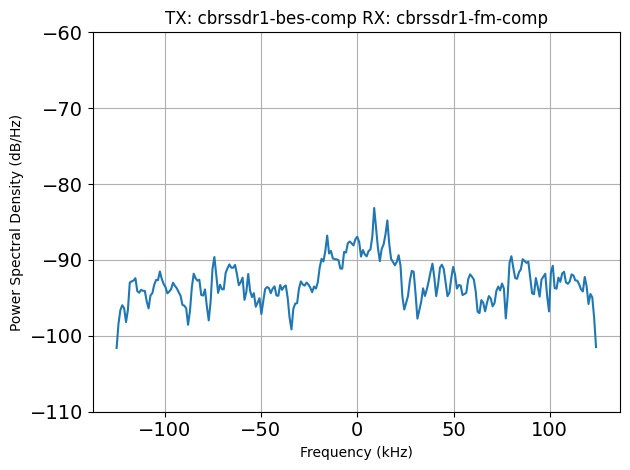

cbrssdr1-fm-comp


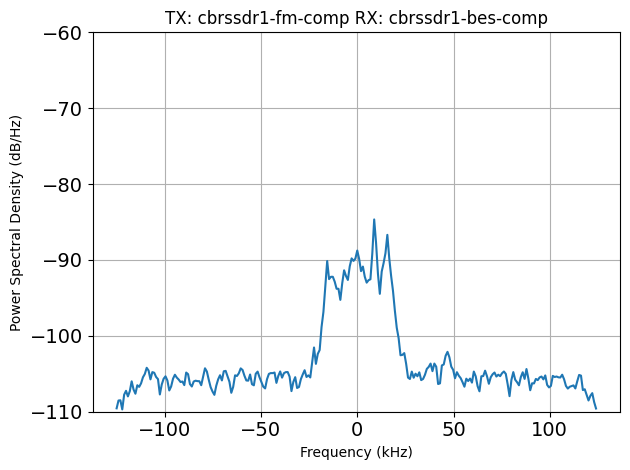

In [5]:
# plot all links
print(samp_rate)
plotOnePSDForEachLink(rx_data, txrxloc, samp_rate)

## Pick Transmitter / Receiver Pair

Enter in the name of the transmitter (TX) and receiver (RX), and the number of the recording (from 0 to repeats-1), which you want to demodulate in the subsequent code.  In particular, set `txloc` and `rxloc` to two different node names that you saw listed above, or in one of the plots above.

In [6]:
# Pick one received signal to demodulate
txloc = 'cbrssdr1-fm-comp'
rxloc = 'cbrssdr1-bes-comp'
repNum = 0

rx_data[txloc] = np.vstack(rx_data[txloc])
rxloc_arr = np.array(txrxloc[txloc])
rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]
print('\nLink: {} to {}. Repetition Num {}.'.format(txloc, rxloc, repNum))
rx0.shape


Link: cbrssdr1-fm-comp to cbrssdr1-bes-comp. Repetition Num 0.


(8192,)

## Low Pass Filtering to out_of_band frequency components

Since the sampling rate in our experiments is about 8 times the bandwidth of the transmitted signal, we let in a lot more noise than is required.  It is better for our synchronization methods to have a higher SNR.  So here we filter the received signal with a finite impulse response (FIR) filter.  Here we use a kaiser filter designed for our sampling and symbol rates.  Since our symbol rate is 1/8 of the sample rate, our cutoff should be more than 1/8.

<Figure size 640x480 with 0 Axes>

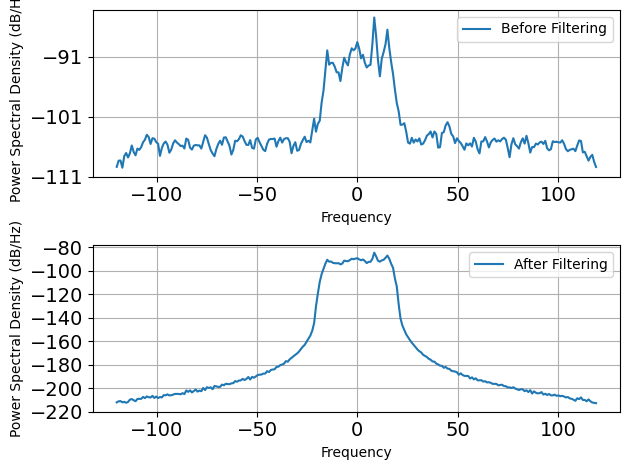

In [7]:
# Design parameters: You can change these parameters depending on the
# (normalized) bandwidth of the signal you have.
stopband_attenuation = 60.0
transition_bandwidth = 0.05
cutoff_norm = 0.15  # normalized bandwidth of the passband
# What order filter do we need?
filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
# Create the filter coefficients
taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
# Use the filter on the received signal
filtered_rx0 = signal.lfilter(taps, 1.0, rx0)

# Plot psd of received signal before and after filtering
plt.figure()
fig, subfigs = plt.subplots(2,1)
subfigs[0].psd(rx0, Fs = 240, label='Before Filtering')
subfigs[0].legend()
subfigs[1].psd(filtered_rx0, Fs = 240, label='After Filtering')
subfigs[1].legend()
plt.tight_layout()
plt.show()

## Preamble synchronization

This section creates the same sampled preamble signal that is used by the transmitter in the transmitted signal.  The packet structure of the transmitted packet is:
0. Quiet: We put 1024 zeros (complex values 0+i0) into the transmitter signal to send first.  This is so that if the receiver starts several samples late, or if the receiver must drop a certain number of samples in order to make sure that its queue is clear from the last sampling, we can still get the start of the packet.  Also it is useful to see periods of low power before a packet starts, it makes seeing the packet in signal plots easier.
1. Preamble: The preamble is used to give the receiver time to perform frequency and symbol synchronization.  In our transmitted signal, the preamble is 16 repetitions of the bits [1, 1, 0, 0].  Because we're using QPSK (with 2 bits per symbol), these are two symbols that are opposite in phase.  The preamble is thus a total length of 64 bits or 32 symbols.
2. Sync Word: The sync word is sent next, it is set of a pseudo random bits that allows the receiver to know exactly when the data bits start.  It does not know this from the preamble because sometimes the receiver misses the start of the preamble, so it can't count on the preamble having exactly 32 symbols.
3. Data bits: These contain the unknown message that the transmitter wants to convey.

This section finds the preamble in the received signal.

In [8]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    x_s = np.zeros(len(x)*OS_Rate)
    x_s[::OS_Rate] = x
    return x_s

# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    k   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % k) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    datacopy = np.copy(data)
    datacopy.shape = (len(datacopy)//k, k)
    binaryValuesArray = [2**(k-1-i) for i in range(k)]
    #binaryValuesArray = 2**np.arange(k)
    print(binaryValuesArray)
    marydata = datacopy.dot(binaryValuesArray)
    return marydata

# PURPOSE: create a modulated signal with the defined preamble
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated preamble signal & srrc pulse
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)

    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s
    pulse = SRRC(alpha, N, Lp)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

    return (s_0_I + 1j*s_0_Q), pulse

In [9]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='same')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    # There may be two preambles because the packet repeats, and the number
    # of recorded samples is much longer than the length of a single packet.
    # Here we give the length of the packet in samples, and we don't look for a
    # preamble that starts at the very end of the packet (so that we don't run
    # out of samples while demodulating the packet.)
    length_of_packet = 3200
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    short_t = range(lagIndex, lagIndex + len(preambleSignal))
    subfigs[0].plot(np.real(rx0), label='Real RX')
    subfigs[0].plot(np.imag(rx0), label='Imag RX')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(preambleSignal))
    subfigs[0].plot(short_t, scale_factor*np.real(preambleSignal), label='Real Preamble')
    subfigs[0].set(ylabel='RX Signal')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    subfigs[1].legend()
    subfigs[1].set(ylabel='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()

    # Plot zoomed in to the place where the preamble signal was detected.
    plt.figure()
    plt.plot(short_t, np.real(rx0[short_t]), label='Real RX Signal')
    plt.plot(short_t, np.imag(rx0[short_t]), label='Imag RX Signal')
    plt.plot(short_t, scale_factor*np.real(preambleSignal), label='Real Preamble')
    plt.ylabel('RX Signal')
    plt.xlabel('Sample Index', fontsize=14)
    plt.legend()

    return lagIndex

First, we create a copy of the preamble signal samples.  Then we find it in the received signal using cross-correlation between the local preamble signal copy and the received signal.

[2, 1]
Max crosscorrelation with preamble at lag 4570


<Figure size 640x480 with 0 Axes>

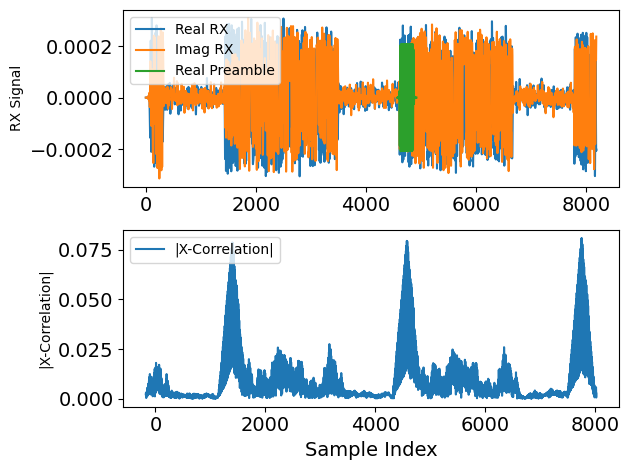

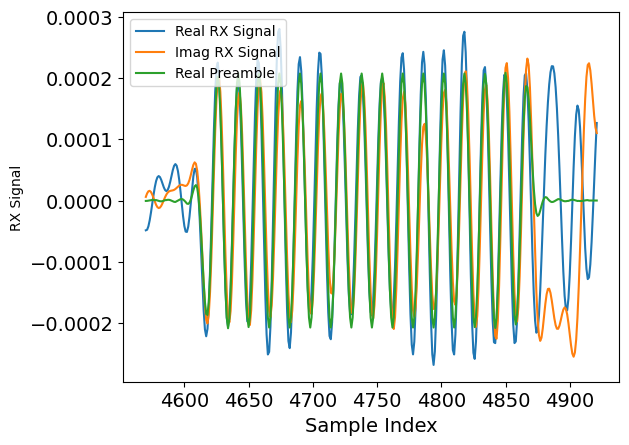

In [10]:
A = 3
N = 8
alpha = 0.5
Lp = 6
packetLenSymbols = 257 # use prior knowledge of how many symbols in packet, in total.
preambleSignal, pulse = createPreambleSignal(A, N, alpha, Lp)
lagIndex = crossCorrelationMax(filtered_rx0, preambleSignal)

**Please check**: You can see from the plots if the preamble is actually found.  If the above plot doesn't actually find a packet, or if you can see the preamble is not aligned with the packet, then debug the above code before proceeding further.

## Estimation and Correction of Frequency Offset

The difference between the carrier frequency generated by the transmitter and the carrier frequency generated by the receiver is called the carrier *frequency offset*, and denoted Δf. This  frequency offset is observed in the received signal at this point -- its phase rotates over time, a full rotation every 1/Δf. Essentially, our desired received signal is multiplied by exp(j2πΔfnT), where exp() is the exponential function, j is the imaginary number, n is the sample number, and T is the sample period. Most receivers estimate Δf and multiply the signal by exp(-j2πΔfnT) to undo the problem. A typical frequency offset is on the order of a few kHz (1000 Hz).

In POWDER, most nodes have white rabbit time and frequency synch enabled. Thus there should be 0 frequency offset if it is working. Sometimes, though, there is a problem and it is not working. It is a good idea to estimate the frequency offset, to make sure. If the frequency offset estimate is on the order of 10 Hz or less, the time sync is almost certainly working (and the non-zero estimate is just because of noise). If the frequency offset is on the order of kHz, then one or more of the nodes is not frequency synched.

In [11]:
# PURPOSE: perform frequency offset estimation and correction.
#          Uses the (complex-valued) preamble signal. The product of
#          the preamble signal and the received signal (at the time
#          when the preamble is received) has a frequency component near
#          zero at the frequency offset.  Find it from the max of the DFT.
#          We need a very fine resolution on that frequency, so we don't
#          use the FFT, we calculate it from the DFT definition.
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal
#          lagIndex: the index of rx0 where the preamble signal has highest
#              cross-correlation
# OUTPUT:  rx1: Frequency-corrected received signal
#          frequencyOffset
#
def estimateFrequencyOffset(rx0, preambleSignal, lagIndex,debug=False):

    # Estimate a frequency offset using the known preamble signal
    if len(preambleSignal) < 200:
        print("estimateFrequencyOffset: Error in Preamble Signal Length")

    # if you don't discard the start and end of the preamble signal, it
    # can overlap with the synch word at its tail end, and this will
    # cause some errors in the frequency estimate.
    discardSamples = 60
    middle_of_preamble = preambleSignal[discardSamples:-discardSamples]
    N        = len(middle_of_preamble)
    # taking the max of 0 and lagIndex+discardSamples for start >=0 rx0 index
    startInd = max(0, lagIndex+discardSamples)
    rx0_part = np.conjugate(rx0[startInd:(startInd + N)])
    prod_rx0_preamble = rx0_part*middle_of_preamble

    # Frequencies at which freq content is calc'ed.
    # We'll multiply the generated matrix by the data to calculate PSD
    # frequencies are normalized to sampling rate
    # MUST BE SET BY USER.  For POWDER with frequency synched nodes, we
    # expect at most 200e-9 frequency offset, which at center frequency of 3.5 GHz
    # and 240k sample rate, is 3.5e9 * 200e-9 / 240e3 = 0.003 Hz.  But we can
    # be conservative and make it larger, no problem.  We want to get the offset
    # down to at most 5 Hz b/c the packet duration is about 20 ms, so that would
    # keep the drift to about 1/10 of a rotation over the whole packet.
    maxFreqOffset   = 0.010000
    deltaFreqOffset = 0.000005
    freqRange    = np.arange(-maxFreqOffset, maxFreqOffset, deltaFreqOffset)
    temp         = (-1j*2*np.pi) * freqRange
    expMat       = np.transpose(np.array([np.exp(temp*i) for i in np.arange(0,N)]))
    # print('expMat.size',expMat.size)
    # print('N',N)
    # print('len(prod_rx0_preamble)',len(prod_rx0_preamble))
    PSD_prod     = np.abs(expMat.dot(prod_rx0_preamble))**2

    #if debug:
    plt.figure()
    plt.plot(250000.0*freqRange,PSD_prod,'r.')
    plt.grid('on')
    plt.xlabel('Frequency Offset')
    plt.ylabel('sqrt PSD')
    # plt.show()

    maxIndexPSD  = np.argmax(PSD_prod)
    maxIndexFreq = freqRange[maxIndexPSD]
    print('[estimateFrequencyOffset] Frequency offset estimate: ' + str(maxIndexFreq*samp_rate) + ' Hz')

    return maxIndexFreq


# PURPOSE: perform frequency offset correction.
# INPUT:   rx0: received signal (with a frequency offset)
#          maxIndexFreq: The frequency offset estimate
# OUTPUT:  rx1: Frequency-corrected received signal
#
def correctFrequencyOffset(rx0, maxIndexFreq):

    # Do frequency correction on the input signal
    expTerm = np.exp((1j*2*np.pi * maxIndexFreq) * np.arange(len(rx0)))
    rx1 = expTerm * rx0
    return rx1

[estimateFrequencyOffset] Frequency offset estimate: -1.0191500421363742e-10 Hz


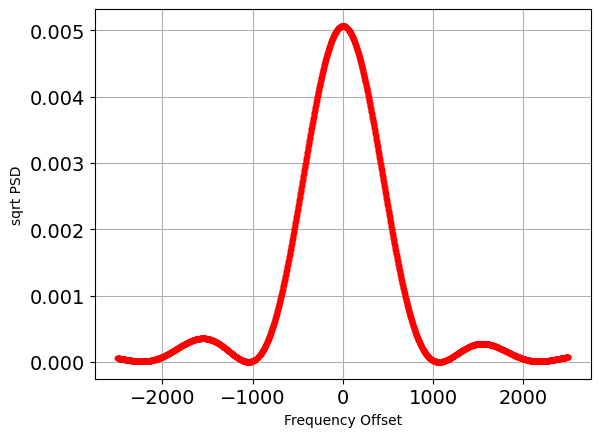

In [12]:
freqOffsetEst = estimateFrequencyOffset(filtered_rx0, preambleSignal, lagIndex)

In [13]:
# Now perform frequency correction, if so desired.
# If the signal has medium to low SNR, this frequency offset estimation method
# isn't perfect, so you might want to skip the correctFrequencyOffset command.
# I do this by calling the frequency correction function with \Delta f = 0 Hz.
rx1 = correctFrequencyOffset(filtered_rx0, 0)   # Don't do frequency correction.
#rx1 = correctFrequencyOffset(filtered_rx0, freqOffsetEst). # Do frequency correction.

## Phase synchronization

Here we make sure that the signal has an eye diagram that shows the signal with an _opening_ at the correct symbol sampling times. If the opening is approximately at the center of the plot, we're on track to have a downsampling operation that takes the symbol values at the right times.

We check this by plotting the eye diagram and the constellation plot, so first we have functions to create these plots.

In [14]:
# PURPOSE: Plot an eye diagram of a signal
# INPUT: y_s: vector of signal samples out of the matched filter
#        N: the number of samples per symbol. Assumes that time 0 is at sample
#        y_s[0]. If not, you must send in an offset integer.
# OUTPUT: none
def plot_eye_diagram(y_s, N, offset=0):
    start_indices = range(int(np.floor(N/2.0)) + offset - 1, len(y_s) - N, N)
    time_vals     = np.arange(-0.5, 0.5+1.0/N, 1.0/N)

    plt.figure()
    for i, start_i in enumerate(start_indices):
        plt.plot(time_vals, y_s[start_i:(start_i+N+1)], 'b-', linewidth=2)

    plt.xlabel(r'Time $t/T_s$', fontsize=16)
    plt.xlim([-0.5, 0.5])
    plt.ylabel('Matched Filter Output', fontsize=16)
    plt.grid(True)
    plt.show()

# PURPOSE: Plot the signal symbol samples on a complex plane
# INPUT:   Received complex values (output of matched filter downsampled)
# OUTPUT:  none
def constellation_plot(rx4):
    # I like a square plot for the constellation so that both dimensions look equal
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.set_aspect(1.0) # Make it a square 1x1 ratio plot
    plt.plot(np.real(rx4), np.imag(rx4),'ro')
    plt.ylabel('Imag(Symbol Sample)', fontsize=14)
    plt.xlabel('Real(Symbol Sample)', fontsize=14)
    plt.grid('on')
    plt.tight_layout()

The preamble starts Lp×N after the lagIndex because Lp×N is the center of pulse shape in the pulse vector. It is essentially the latency introduced by having a 2Lp×N long pulse centered at time 0.

My simple phase synch algorithm uses the fact that the odd numbered preamble symbols are at an angle of 45 degrees. If they are not, they should be rotated to be at an angle of 45 degrees. If we only use one preamble symbol value, its noise will affect our phase synch too much. I thus use the fact that there are 32 preamble symbols or 16 odd-numbered ones. Average all of the odd numbered symbol values together to get their angle.

Turn signal by correction angle of: 1.818284 degrees
New angle of first preamble symbol: -131.111482 degrees


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Figure size 640x480 with 0 Axes>

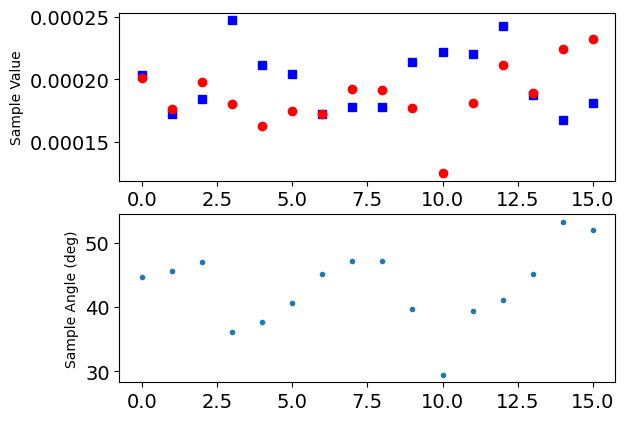

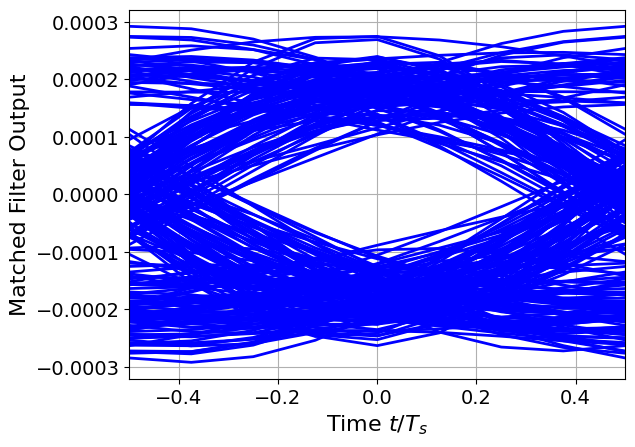

In [15]:
preambleStart = lagIndex + Lp*N + 1   # There's also the delay b/c the SRRC pulse is this long.
#plot_eye_diagram(np.imag(rx1), N, offset=preambleStart)
numFirstFew = 16
oddPreambleSymbols =rx1[preambleStart+N:preambleStart+N+2*N*numFirstFew:(2*N)]
len(oddPreambleSymbols)

# For debug to make sure we're getting the expected preamble and sync symbols
plt.figure()
fig, subfigs = plt.subplots(2,1)
subfigs[0].plot(range(numFirstFew), np.real(oddPreambleSymbols), 'bs', range(numFirstFew), np.imag(oddPreambleSymbols), 'ro')
subfigs[0].set(ylabel='Sample Value')
subfigs[1].plot(range(numFirstFew), (180/np.pi)*np.angle(oddPreambleSymbols),'.')
subfigs[1].set(ylabel='Odd Preamble Symbol #')
plt.ylabel('Sample Angle (deg)')

#############################################################################
# Estimate the Phase of the odd preamble symbols and then correct it.
# Every odd (1, 3, ...) preamble symbol, should be at an angle of pi/4.
# Average a few of the first symbol values, find the angle of that average
avgOddPreambleSymbol = np.mean(oddPreambleSymbols)
correctionAngle = np.pi/4 - np.angle(avgOddPreambleSymbol)
print("Turn signal by correction angle of: %f degrees" % (correctionAngle*180/np.pi))
# Correct it: Multiply each sample by exp(j*correctionAngle)
rx2 = rx1 * np.exp(1j*correctionAngle)
print("New angle of first preamble symbol: %f degrees" % (np.angle(rx2[preambleStart], deg=True)))

# Plot the Eye Diagram
plot_eye_diagram(rx2[preambleStart:preambleStart + packetLenSymbols*N], N, 0)


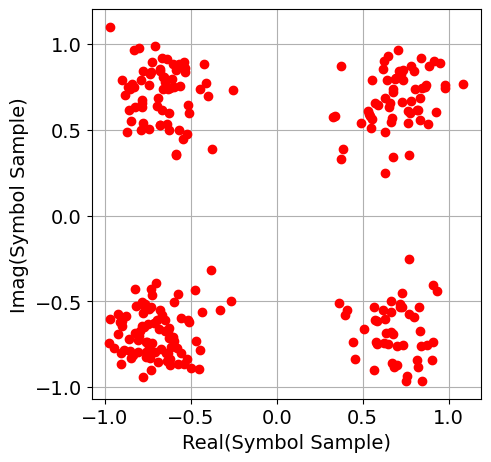

In [16]:
###########################################
# Downsample
# INPUT: Synched matched filter output
# OUTPUT: Symbol Samples (at n*T_sy)
rx3 = rx2[preambleStart:preambleStart + packetLenSymbols*N:N]

###########################################
# Digital automatic gain control (AGC)
# OUTPUT: symbol values that have magnitude (abs) close to  1
#   Note magnitude = sqrt( real**2 + imag**2 )
rx4 = rx3 / np.median(np.abs(rx3))

## Debug options:
#print(np.abs(rx4))
## Ignore initial samples that are very close to the origin, compared to later samples.
#startsymbol = np.where(np.abs(rx3)>0.2)[0][0]
#rx4 = rx4[startsymbol:]
constellation_plot(rx4)

## Symbol Detection

The maximum _a posteriori_ (MAP) receiver finds the  symbol in the constellation that is closest in the Euclidean sense to the measured symbol value.  That is the lowest probability of  error decision that can be made, assuming that each symbol is equally likely, and the noise is zero-mean additive Gaussian noise.  Our `findClosestComplex` implements this MAP detector.  Then the `mary2binary` converts the symbols to bits.

In [17]:
# PURPOSE: Find the symbols which are closest in the complex plane
#          to the measured complex received signal values.
# INPUT:   Received r_hat values (output of matched filter downsampled),
#          and possible signal space complex values.
# OUTPUT:  m-ary symbol indices in 0...length(outputVec)-1
def findClosestComplex(r_hat, outputVec):
    # outputVec is a 4-length vector for QPSK, would be M for M-QAM or M-PSK.
    # This checks, one symbol sample at a time,  which complex symbol value
    # is closest in the complex plane.
    data_out = [np.argmin(np.abs(r-outputVec)) for r in r_hat]
    return data_out

# Purpose: Convert M-ary data to binary data
#          each m-ary value input in "data" is converted to
#          log2(M) binary values.
# INPUT: M-ary digit vector
# OUTPUT: Binary digit vector, with length equal to the number
#         of values in data multiplied by log2(M)
def mary2binary(data, M):
    length = len(data) # number of values in data
    log2M = round(np.log2(M)) # integer number of bits per data value
    format_string = '0' + str(log2M) + 'b'
    binarydata = np.zeros((1,length*log2M))
    count = 0
    for each in data:
        binval = format(int(each), format_string)
        for i in range(log2M):
            binarydata[0][count+i] = int(binval[i])
        count = count + log2M
    return binarydata

In [18]:
###########################################
# Symbol Decisions
# INPUT: Symbol Samples
# OUTPUT: Bits
outputVec = np.array([1+1j, -1+1j, 1-1j, -1-1j])
mary_out  = findClosestComplex(rx4, outputVec)
print(mary_out[:40])
binary_out = mary2binary(mary_out,4)[0]
#print('The Decoded data bits are: binary_out',binary_out)

[3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 2, 3, 2, 1, 0, 0]


## Message extraction

Plot a comparison of what the first symbols should be, compared to what they are. If the received symbol estimates do not agree with the known preamble and sync word, then you should debug prior to here.

[2, 1]
There are %d bits in the received data. 434
knownDataBitLength =  434.0


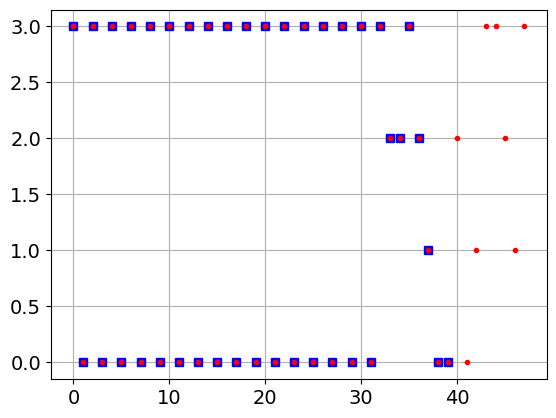

In [19]:
###########################################
# Sync Word Discovery and Data Bits Extraction
#
M           = 4
k           = np.log2(M)

syncWord    = np.asarray([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0])
preamble    = np.concatenate( np.repeat( [[1, 1, 0, 0, 1, 1, 0, 0 ]], 8, axis=0), axis=None)
symbolsForHeader = binary2mary(np.hstack([preamble, syncWord]), M)
headerLen   = len(syncWord) + len(preamble)

# Plot a comparison of what the first symbols should be, compared to what they are.
# If the received symbol estimates do not agree with the known preamble and sync
# word, then you should debug prior to here.
plt.figure()
plt.plot(range(len(symbolsForHeader)), symbolsForHeader, 'bs')
plt.plot(range(len(mary_out[:48])), mary_out[:48], 'r.')
plt.grid(True)

rxDataBits = binary_out[headerLen:]
knownDataBitLength = packetLenSymbols*k - headerLen

print("There are %d bits in the received data.", len(rxDataBits))
print("knownDataBitLength = ", knownDataBitLength)

In [20]:
#
# PURPOSE:  Convert a vector of (float) zeros and ones to a string (char array)
# INPUT:    Expects a row vector of zeros and ones, a multiple of 7 length
#   The most significant bit of each character is always first.
# OUTPUT:   A string
#
def binvector2str_v2(binvector):

    totalbits = len(binvector)
    if ((totalbits%7) > 1e-6):
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
        print('  You must be missing a few bits or have a few extra.')

    # We are using 7 bits per character in ASCII encoding
    # Put 7 1/0s into each row of the row_per_char 2D array
    row_per_char = binvector.reshape( totalbits//7, 7)

    str_out = ''  # Initialize character vector
    for bit_ints in row_per_char:
        # Convert the vector of 1.0/0.0 into a string of '1' and '0'
        bitstring   = "".join(str(int(z)) for z in bit_ints)
        # Convert the string into an integer using base 2
        # then into an ascii character
        # Then add it to the end of str_out
        str_out    += chr(int( bitstring, 2))

    return str_out

In [21]:
###########################################################################
print('The Data Bits are:\n',rxDataBits)
extract_message = binvector2str_v2(rxDataBits)
print('The Extracted String is:\n',extract_message)

The Data Bits are:
 [1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 

If the text is readable, or almost readable, you're successful. Turn in your message and this ipynb to the Canvas assignment. There might be some bit errors, and thus character errors, if the SNR was not high enough. There are more than one link, and the rx signal was recorded multiple times. You could change the txloc, rxloc, and repNum in the "Pick Transmitter / Receiver Pair" section.

If *all* of the characters are in error, there is probably a bigger problem. For example, there might be an error in what bit strings the code is assigning to each symbol. Or the synchronization might be off by one symbol. Or the phase synchronization may not have worked -- if the code applied the wrong phase shift, then all of the packet's symbols would be rotated and thus detected to be the wrong symbol.